# Custom Transformer

In [8]:
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import set_config; set_config(display='diagram')

👇 Consider the following dataset

In [6]:
import pandas as pd

data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/08-Workflow/custom_transformer_data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


In [4]:
print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   customer_state       1000 non-null   object
 1   seller_state         1000 non-null   object
 2   product_weight_g     1000 non-null   int64 
 3   product_length_cm    1000 non-null   int64 
 4   product_height_cm    1000 non-null   int64 
 5   product_width_cm     1000 non-null   int64 
 6   days_until_delivery  1000 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 54.8+ KB
None


- Each observation of the dataset represents an item being delivered from a  `seller_state` to a `customer_state`. 
- Other columns describe the packaging properties of each item.

🎯 The target is the number of days between the order and the delivery.

<AxesSubplot:xlabel='days_until_delivery', ylabel='Count'>

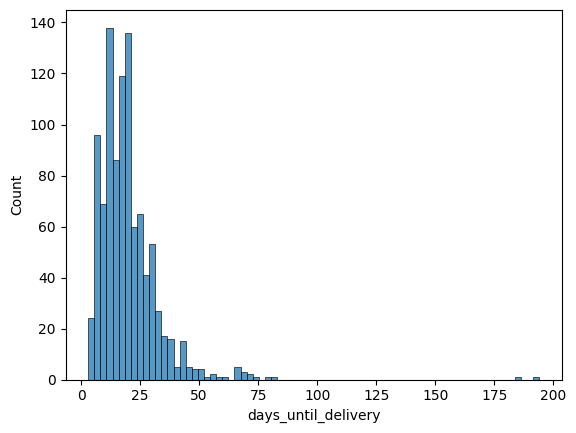

In [9]:
# Check target
sns.histplot(data.days_until_delivery)

## 1. Pipeline

👇 Create a scikit-learn pipeline named `pipe`:

- Engineer a `volume` feature from the dimensions features
- Preserve the original product dimensions features for training
- Scale all numerical features
- Encode the categorical features
- Add a default `Ridge` regression estimator

**Note:** for this challenge, ignore the holdout method, so no need to `train_test_split`!

<details><summary>Hints</summary>

- There are many ways to create your preprocessed matrix (using `ColumnTransformer` and/or `FeatureUnion`). 
    
- If your transformed feature matrix look weird, it may be stored as "sparse" by the default behavior of `OneHotEncoder(sparse_output=True)`. Use `.todense()` to turn it back to a dense matrix

</details>

In [48]:
from sklearn.preprocessing import FunctionTransformer

In [101]:
data ['volume'] = data ['product_length_cm'] * data ['product_height_cm'] * data ['product_width_cm']
data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery,volume
0,RJ,SP,1825,53,10,40,9,21200
1,RJ,SP,700,65,18,28,9,32760
2,RJ,SP,1825,53,10,40,11,21200
3,RJ,SP,1825,53,10,40,12,21200
4,RJ,SP,1825,53,10,40,14,21200
...,...,...,...,...,...,...,...,...
995,RJ,SP,16800,63,58,24,30,87696
996,RS,SP,675,40,18,35,19,25200
997,RJ,SP,2050,45,15,35,32,23625
998,BA,SP,8750,52,51,17,33,45084


In [103]:
# YOUR CODE HERE


categorical_features = ['customer_state', 'seller_state']
numerical_features = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'volume']

preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features),
                                               ('cat', OneHotEncoder(), categorical_features)])

pipe = Pipeline([('preprocessor', preprocessor),
                 ('ridge', Ridge())])

pipe



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['product_weight_g',
                                                   'product_length_cm',
                                                   'product_height_cm',
                                                   'product_width_cm',
                                                   'volume']),
                                                 ('cat', OneHotEncoder(),
                                                  ['customer_state',
                                                   'seller_state'])])),
                ('ridge', Ridge())])

#### 🧪 Test your pipe

In [104]:
from nbresult import ChallengeResult

pipe_test = pipe

# Check that it doesn't crash
assert pipe_test.fit(X, y)

result = ChallengeResult(
    'pipe', 
    shape = pipe_test[:-1].fit_transform(X).shape
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/Laetitia/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/Laetitia/code/juliensoudet/05-ML/08-Workflow/data-custom-transformer/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_pipe.py::TestPipe::test_pipe_not_crashing PASSED                    [100%]

============================== 1 passed in 1.45s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master



In [28]:
! git add tests/pipe.pickle

! git commit -m 'Completed pipe step'

! git push origin master


On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   02-Custom-Transformer.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
Everything up-to-date


## 2. Train and Predict

👇 Let's imagine `data` is your entire training set.

- `cross_validate` your pipeline on this dataset (❗️low r2 score are expected)
- Now, imagine you just received an new order `new_data`: predict it's duration of delivery in a variable `prediction`

In [58]:
new_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/08-Workflow/custom_transformer_new_order.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [106]:
data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery,volume
0,RJ,SP,1825,53,10,40,9,21200
1,RJ,SP,700,65,18,28,9,32760
2,RJ,SP,1825,53,10,40,11,21200
3,RJ,SP,1825,53,10,40,12,21200
4,RJ,SP,1825,53,10,40,14,21200
...,...,...,...,...,...,...,...,...
995,RJ,SP,16800,63,58,24,30,87696
996,RS,SP,675,40,18,35,19,25200
997,RJ,SP,2050,45,15,35,32,23625
998,BA,SP,8750,52,51,17,33,45084


In [110]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

X = data.drop (columns =['days_until_delivery'])
y = data ['days_until_delivery']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.01 )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((990, 7), (10, 7), (990,), (10,))

In [105]:
print(data.columns)

Index(['customer_state', 'seller_state', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'days_until_delivery', 'volume'],
      dtype='object')


In [113]:
# YOUR CODE HERE
# Transform X using the preprocessor
X_processed = preprocessor.transform(X_train)
print(X_processed)

# Perform cross-validation
cv_results = cross_validate(pipe, X_processed, y_train, cv=5, scoring='r2')

cv_results





  (0, 0)	-1.2097982602344435
  (0, 1)	-0.2146413715316712
  (0, 2)	-1.3553641786730255
  (0, 3)	0.7422287577256115
  (0, 4)	-1.124170626943125
  (0, 28)	1.0
  (0, 31)	1.0
  (1, 0)	0.7614874445179237
  (1, 1)	0.2013302787235058
  (1, 2)	1.4089927021612099
  (1, 3)	-1.047450403822334
  (1, 4)	0.39982267120929904
  (1, 22)	1.0
  (1, 31)	1.0
  (2, 0)	0.8747096507641938
  (2, 1)	0.3677189388255766
  (2, 2)	0.7639760966332215
  (2, 3)	-0.7220541926317985
  (2, 4)	0.4283859533085453
  (2, 22)	1.0
  (2, 31)	1.0
  (3, 0)	0.06177420991597451
  (3, 1)	0.11813594867247042
  (3, 2)	1.1325570140777863
  (3, 3)	0.010087282546906502
  :	:
  (986, 3)	-0.5593560870365307
  (986, 4)	1.1554513158348134
  (986, 28)	1.0
  (986, 31)	1.0
  (987, 0)	0.6186532766380137
  (987, 1)	-0.2146413715316712
  (987, 2)	0.948266555355504
  (987, 3)	-0.315308928643629
  (987, 4)	0.7615005938945599
  (987, 17)	1.0
  (987, 31)	1.0
  (988, 0)	1.2448591711846921
  (988, 1)	2.3643828600504264
  (988, 2)	-1.4935820227147374
  (

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/__init__.py", line 423, in _get_column_indices
    all_columns = X.columns
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/sparse/_base.py", line 764, in __getattr__
    raise AttributeError(attr + " not found")
AttributeError: columns not found

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 751, in fit_transform
    self._validate_column_callables(X)
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 459, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "/Users/Laetitia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/__init__.py", line 425, in _get_column_indices
    raise ValueError(
ValueError: Specifying the columns using strings is only supported for pandas DataFrames


In [87]:

test_scores = cv_results['test_score']

test_scores
mean_test_score = np.nanmean(test_scores)
print("Mean test score:", mean_test_score)

Mean test score: 0.12458987273212563


In [98]:

new_data ['volume'] = new_data ['product_length_cm'] * new_data['product_height_cm'] * new_data ['product_width_cm']
new_data

X_new_processed = preprocessor.transform(new_data)
print (X_new_processed)

prediction = pipe.predict(X_new_processed)


  (0, 0)	-1.1328071599869798
  (0, 1)	0.03494161862143501
  (0, 2)	-1.3553641786730255
  (0, 3)	0.7422287577256115
  (0, 4)	-1.0870754553856625
  (0, 22)	1.0
  (0, 31)	1.0


ValueError: X has 32 features, but ColumnTransformer is expecting 7 features as input.

In [71]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'prediction',
    prediction = prediction
)

result.write()
print(result.check())


NameError: name 'prediction' is not defined

🏁 Congratulation. Don't forget to add, commit and push your notebook.